In [1]:
import pandas as pd
from IPython.display import Markdown

import tb_incubator.constants as const
from tb_incubator.constants import set_project_base_path
from tb_incubator.model import build_model
from tb_incubator.plotting import set_plot_label, display_plot, plot_model_vs_actual
from tb_incubator.input import load_targets, load_param_info, get_param_table
from tb_incubator.reporting import load_report_section

pd.options.plotting.backend = "plotly"  
project_paths = set_project_base_path("../tb_incubator/")

## Introduction

In [2]:
load_report_section('reporting.yaml', 'introduction')
load_report_section('reporting.yaml', 'introduction2')

Indonesia is ranked as the second highest tuberculosis (TB) burden in the world [@whotb2023]. According to the most recent Global TB Report, TB incidence in Indonesia increased by 18% in 2022 compared to 2015. TB prevalence was estimated during the 2013-2014 national TB prevalence survey. It is reported that the TB prevalence estimate was 759 (95% CI 590-961) smear-positive, bacteriologically-confirmed infections per 100,000 population in people aged over 15 years [@indoprevsurv2015]. This estimate provides additional insights regarding the underreporting of TB cases.

Indonesia has committed to eliminating TB by 2030. To achieve this goal, the Ministry of Health (MoH) and the National TB Control Programme (NTCP) have developed six strategic plans for 2020–2024. Modelling can be a powerful tool to support these plans by providing epidemiological insights into TB dynamics and control, and by helping optimise strategies through projections of future trends based on current efforts [@trauer2016]. However, our preliminary survey revealed that very few TB models, particularly those for programme evaluation purposes, have been developed for Indonesia.

The Epidemiological Modelling Unit at Monash University has developed software to create a TB transmission model. This tool is based on the Susceptible-Infectious-Recovered (SIR) compartmental model framework. Models for several countries have already been developed to assess the impact of interventions by local TB control programmes [@ragonnet2022, @ragonnet2019, @doan2019, @trauer2016]. 


@fig-notif illustrates TB case notifications in Indonesia in 2000-2022 [@whotb2023]. The notification began to rise in 2016 until 2018, followed by a slight reduction in 2019 and significant drop in 2020. The trend then starts to increase again in 2021, followed by a dramatic increase in 2022. Here we assume that the rise in TB notifications in 2016 may be attributed to improvements in the TB detection programme, alongside the implementation of active case finding (ACF) in 2018-2019 [@moh2020]. The decline in notifications in 2020 may also be related to the impact of the COVID-19 pandemic [@surendra2023]. We aim to capture these dynamics, particularly over the last decade, where improved programmatic interventions have been implemented.


In [3]:
targets = load_targets()
indicator_names = const.indicator_names
compartments = const.compartments

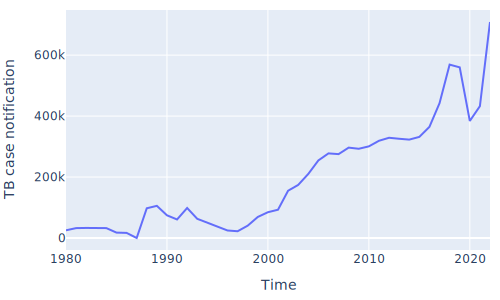

In [4]:
#| label: fig-notif
#| fig-cap: "Case notifications for tuberculosis in Indonesia"
#| fig-pos: '!tbph'

notif = targets["notif"]
fig = notif.plot()
fig.update_layout(showlegend=False, xaxis_title='Time')
set_plot_label(fig, indicator_names, "TB case notification")
fig.update_layout(margin={'t':10,'l':10,'b':10,'r':10})
fig.show(renderer="svg", width=500, height=300)

## Model construction

In [5]:
param_info = load_param_info()
params = param_info["value"]

In [6]:
model, desc = build_model(params)
Markdown(desc)

We used the [summer framework](https://summer2.readthedocs.io/en/latest/) to construct a compartmental model of tuberculosis (TB) dynamics. The base model consists of 6 compartments: susceptible, early latent, late latent, infectious, recovered, missed--with flows added to represent the transitions and interactions between compartments. The susceptible (S) compartment includes individuals who have never had TB and are at risk of being infected by Mycobacterium tuberculosis. Latent TB infection is modelled using two compartments: early latent (E) and late latent (L). Latently infected individuals who progress to active TB move to the infectious (I) compartment. Those who recover through self-recovery are transferred to the recovery (R) compartment. We also account for under-reporting by modelling transitions of some individuals from the infectious (I) compartment to the missed (M) compartment.

Our model predicts the TB dynamics from 1820 to 2024. We mostly used estimates from previous study [@ragonnet2022] to inform TB progression and natural history of TB. We also fitted some parameters to local data on TB notifications [@whotb2023] and prevalence [@indoprevsurv2015], while considering uncertainty around TB progression parameters (see @tbl-params). Initially, we introduce a small number of population and seed infectious individuals to the model. Births are modelled using a time-variant function of the population entry rate. The entry rate was calculated by dividing the yearly population difference by the duration of the run-in period. Time-varying and age-specific non-TB-related mortality was applied to all compartments to represent deaths from non-TB causes. Estimates from the United Nations’ World Population Prospects [@unwpp2024] were used as reference data. We also assume that the population is closed, where the number of births replaces the total number of deaths each year. 

The detection rate refers to the progression of individuals with active TB (I) to the recovered (R) compartment, based on the assumption that detected individuals receive immediate treatment upon diagnosis, leading to their recovery. Furthermore, we implement changes in the diagnostic algorithm to model the improved diagnostic test (GeneXpert) utilisation. We assume that utilisation is proportional to the number of confirmed cases identified by GeneXpert. The calculated improvement in diagnostic sensitivity is then applied to the following year's data. On the other hand, the flow of under-reporting, or “missing” TB cases, refers to the potential sensitivity bias multiplied by the detection function.  

We use estimates reported in a previous study [@ragonnet2022] for TB-specific mortality, self-recovery rate, and age-specific infectiousness to inform the TB dynamics. Reinfection was illustrated in two different ways: flows from late latent (L) to early latent compartment (E) and from individuals who have recovered from TB (R) to early latent. Both pathways can be adjusted to reflect different reinfection risks compared to infection-naïve individuals. Progression flows from latent compartments to infectious compartment are also implemented to model the progression from individuals with latent infection to active TB. We stratified the model based on 5 age groups: 0-4, 5-14, 15-34, 35-49, 50-100. Age group-specific adjustments were applied for population death flows, latency flows, and infectiousness.

In [7]:
test_params = {
	'contact_rate': 9.543921666073745,
	'self_recovery_rate': 0.29688347664390236,
	'screening_scaleup_shape': 0.19889392155636598,
	'screening_inflection_time': 2005.3016735363497,
	'time_to_screening_end_asymp': 0.3361714758423252,
	'rr_infection_latent': 0.116003030825429,
	'rr_infection_recovered': 0.8720080623263372,
	'seed_time': 1860.49881702568,
	'seed_duration': 19.549815951426623,
	'seed_rate': 70.64648160388384,
	'base_sensitivity': 0.2867398245514573,
	'genexpert_sensitivity': 0.826222381252117,
	'progression_multiplier': 1.436023746975478,
}


In [8]:
model.run(params)

## Results

In [9]:
outs = model.get_derived_outputs_df()

In [10]:
load_report_section('reporting.yaml', 'result-compartment')

@fig-compsize illustrates the size of each compartment in our base model and percentage of latently infected individuals. The model fits with the demographic trends from the UN population estimates [@unwpp2024] and national census data [@indostatistics2020]. The model predicts that epidemics will occur between 1910 and 1920, as the number of susceptible individuals decreases, while the number of individuals in the late latent stage of TB infection increases. As the population grows exponentially, the number of susceptible individuals begins to rise again in the 1950s, with a continued increase in the late latent compartment. We also calculated the percentage of people with latent TB by dividing the sum of people in the early latent and late latent compartments by the total population.


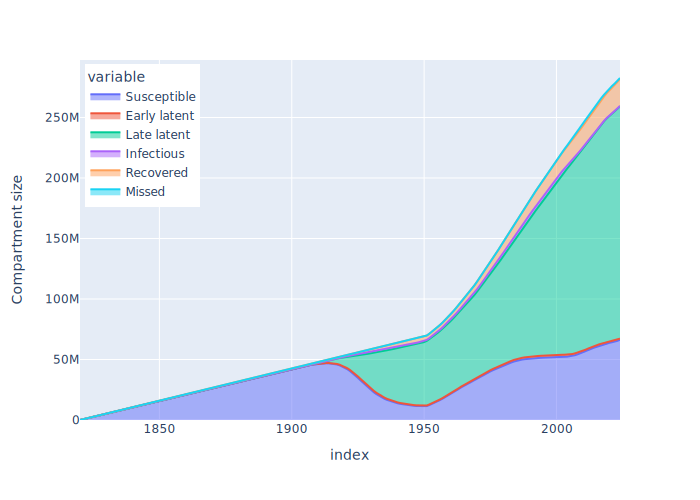

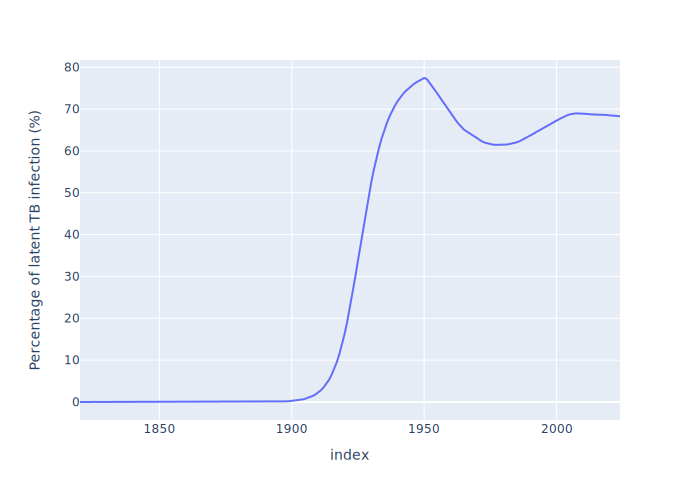

In [11]:
#| layout-ncol: 2
#| label: fig-compsize
#| fig-cap: "Base model of TB dynamics in Indonesia."
#| fig-subcap: 
#|   - "Compartment size"
#|   - "Percentage of latent TB infection"
#| fig-pos: '!h'

fig = outs[[f"comp_size_{c}" for c in compartments]].plot.area()
#fig.add_scatter(x=targets["census_pop"].index, y=targets["census_pop"], mode="markers", name="Census data")
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
set_plot_label(fig, indicator_names, "Compartment size")
display_plot(fig, "comp_size", "svg")

fig = outs["percentage_latent"].plot()
fig.update_layout(showlegend=False)
set_plot_label(fig, indicator_names, "Percentage of latent TB infection (%)")
display_plot(fig, "percentage_latent", "svg")

In [12]:
load_report_section('reporting.yaml', 'result-notifprev')

The results of our baseline calibration are shown in @fig-notifprev, where the model was fitted to local TB epidemiology data, particularly data for case notifications and prevalence. This demonstrates that the baseline model can capture the general dynamics from 2000 to 2020 and aligns well with the prevalence data from the 2013-2014 survey. 


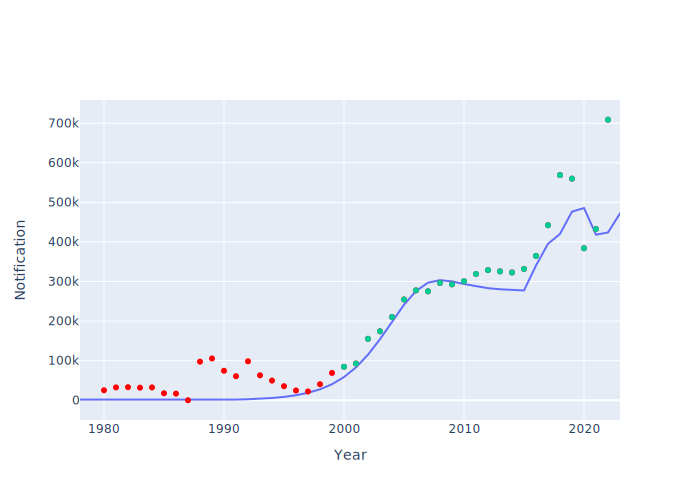

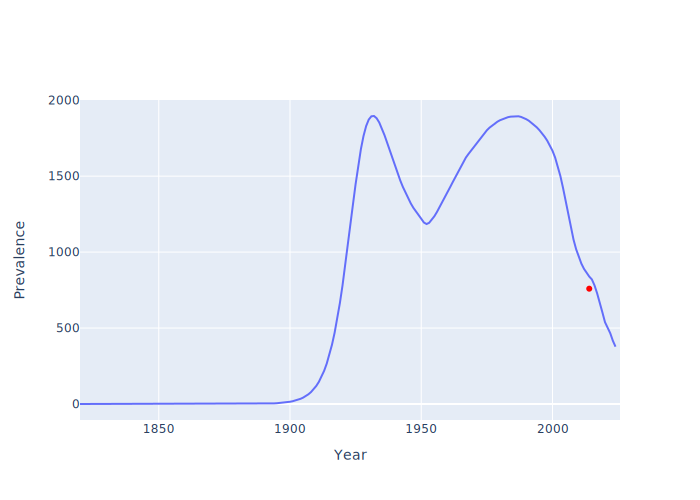

In [13]:
#| label: fig-notifprev
#| fig-cap: "Comparison between model outputs and local data for calibration targets. The red dots represent the actual data from all periods, while the green dots indicate the data specifically used for calibration targets. For prevalence, all actual data is used as the calibration target."
#| fig-subcap: 
#|   - "TB notifications"
#|   - "TB prevalence"
#| layout-ncol: 2
#| fig-pos: '!ht'

fig = plot_model_vs_actual(outs, 
                     targets["notif"],
                     "notification",
                     "Notification",
                     "",
                     "Actual data (All periods)")
#fig.add_scatter(x=targets["new_cases"].index, y=targets["new_cases"], mode="markers", name="NTCP data")
fig.add_scatter(x=targets["notif2000"].index, y=targets["notif2000"], mode="markers", name="Target data")
fig.update_layout(showlegend=False)
fig.update_xaxes(range=[1978, 2023])
display_plot(fig, "notification", "svg")

fig = plot_model_vs_actual(outs, 
                     targets["prevalence"],
                     "prevalence",
                     "Prevalence",
                     "",
                     "Actual data")
fig.update_layout(showlegend=False)
display_plot(fig, "prevalence", "svg")

In [14]:
load_report_section('reporting.yaml', 'result-conclusion')

We believe that further improvements can be made to the model, and obtaining more reliable data will help us better capture overall trends. Once we establish the baseline epidemic, we can investigate counterfactual scenarios by introducing or removing interventions. This approach will allow us to evaluate their effectiveness and potential impact.

In [15]:
#fig = outs[["incidence", "prevalence", "mortality"]].plot()
#set_plot_label(fig, indicator_names, "value")
#display_plot(fig, "inc_prev_mort", "svg")
#fig

In [16]:
#actual_data = targets["notif"] / targets["incidence_num"] * 100
#fig = plot_model_vs_actual(outs, 
                     #actual_data,
                     #"notification_per_incidence",
                     #"Notification per incidence",
                     #"",
                     #"Actual data")

#display_plot(fig, "notification_per_incidence", "svg")

\newpage
## Supplementary

In [17]:
#| label: tbl-params
#| tbl-cap: Model parameters
#| tbl-cap-location: top

fixed_param_table = get_param_table(param_info)
Markdown(fixed_param_table.to_markdown())


| Parameter                                                                   | Value                                               | Unit                        | Source                                                                                        |
|:----------------------------------------------------------------------------|:----------------------------------------------------|:----------------------------|:----------------------------------------------------------------------------------------------|
| Start population size                                                       | 1.0                                                 | person                      | A value to avoid dividing by zero in the force of infection calculation                       |
| Age infectiousness switch                                                   | 15.0                                                | years old                   | Set based on duration of BCG protection [@ngupidop2016, @roy2019]                             |
| TB-specific death rate                                                      | 0.1                                                 | per year                    | United Nations Population Division data for Indonesia [@unwpp2024]                            |
| Contact rate                                                                | 9.54                                                | contacts per person per day | Fitted [@ragonnet2022]                                                                        |
| Self-recovery rate                                                          | 0.29                                                | per year                    | Fitted [@ragonnet2020]                                                                        |
| Relative risk of reinfection while latently infected (ref. infection-naive) | 0.12                                                |                             | Fitted [@andrews2012]                                                                         |
| Relative risk of reinfection after recovery (ref. infection-naive)          | 0.87                                                |                             | Fitted [@andrews2012]                                                                         |
| Rate of rapid progression to active TB, based on age groups                 | 0: 2.4/5: 2.0/15: 0.1/35: 0.1/50: 0.1               | per year                    | Arbitrary value selected from a parameter range published in a previous study [@ragonnet2017] |
| Rate of late reactivation, based on age groups                              | 0: 7e-09/5: 0.0023/15: 0.0012/35: 0.0012/50: 0.0012 | per year                    | Arbitrary value selected from a parameter range published in a previous study [@ragonnet2017] |
| Rate of stabilization from early to late latency, based on age groups       | 0: 4.4/5: 4.4/15: 2.0/35: 2.0/50: 2.0               | per year                    | Arbitrary value selected from a parameter range published in a previous study [@ragonnet2017] |
| TB progression multiplier                                                   | 1.44                                                |                             | Arbitrary value selected from a parameter range published in a previous study [@ragonnet2022] |
| Seed time                                                                   | 1881.5                                              |                             | Fitted                                                                                        |
| Seed duration                                                               | 19.55                                               | days                        | Fitted                                                                                        |
| Seed rate                                                                   | 70.65                                               | persons per day             | Fitted                                                                                        |
| Passive screening shape                                                     | 0.199                                               |                             | Fitted                                                                                        |
| Passive screening inflection time                                           | 2009.3                                              |                             | Fitted                                                                                        |
| Time from active TB to be screened                                          | 0.336                                               |                             | Fitted                                                                                        |
| Preceding diagnostic algorithm sensitivity.                                 | 0.287                                               |                             | Fitted                                                                                        |
| Diagnostic test sensitivity                                                 | 0.826                                               |                             | Fitted                                                                                        |

\newpage
## References